## nn 作って plasiticc で活かしたい
やること
 * 基本的な mlp 作成　& 性能調査
 * cnn 使った band 間の情報抽出

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.transforms as transforms


import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import pandas as pd
from scipy.special import erfinv

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import StandardScaler
import lightgbm

from logging import getLogger
from tqdm import tqdm
import argparse
import datetime
import pickle
import warnings
from matplotlib import pyplot as plt
import seaborn as sns

import gc
import sys
from multiprocessing import Pool
sys.path.append('../')

from tools.my_logging import logInit
from tools.feature_tools import feature_engineering
from tools.objective_function import weighted_multi_logloss, lgb_multi_weighted_logloss, wloss_objective, wloss_metric, softmax, calc_team_score
from tools.model_io import save_models, load_models
from tools.fold_resampling import get_fold_resampling_dict

In [3]:
NTHREAD = 60
%load_ext autoreload
%autoreload 2

## nn の作成開始
まずは　mlp から。
 * ネットワーク構造、batchnorm の有無、drop out の値を　configurable に
 * cnn との連携を意識
 * 

In [4]:
class plasticcNet(nn.Module):
    def __init__(self, mlp_shapes, band_cnn_idxes=None):
        super(plasticcNet, self).__init__()
        #self.activation = torch.nn.ReLU()
        self.activation = torch.nn.ELU()
        self.band_cnn_idxes = band_cnn_idxes
        # band 軽特徴量間の幾何的構造に基づく関係性を捉える cnn 
        self.band_conv_nets = []
        if band_cnn_idxes:
            for band_cnn_idx in band_cnn_idxes:
                None
            None
        self.dense_nets = nn.ModuleList()
        #self.dense_nets = []
        self.batch_norms = nn.ModuleList()
        #self.batch_norms = []
        self.dropouts = nn.ModuleList()
        #self.dropouts = []
        # mlp を組む
        for i, shape in enumerate(mlp_shapes):
            self.dense_nets.append(nn.Linear(shape[0], shape[1]))
            #self.batch_norms.append(nn.LayerNorm(shape[1]))
            self.batch_norms.append(nn.BatchNorm1d(shape[1]))
            if i == 0:
                p = 0.0
            elif i == len(mlp_shapes) - 1:
                p = 0.25
            else:
                p = 0.5
            self.dropouts.append(nn.Dropout(p=p))
            
    def forward(self, x):
        if len(self.band_conv_nets) > 0:
            for band_conv_net in self.band_conv_nets:
                None
        for i, nets in enumerate(list(zip(self.dense_nets, self.batch_norms, self.dropouts))):
            dense_net, batch_norm, dropout = nets
            if i < len(self.dense_nets) - 1:
                #x = torch.relu(dense_net(x))
                x = self.activation(dense_net(x))
                #ac = torch.nn.LeakyReLU()
                #ac = torch.nn.ELU()
                #ac = torch.nn.PReLU()
                #x = ac(x)
                #x = torch.selu(dense_net(x))
                #x = torch.tanh(dense_net(x))
                x = batch_norm(x)
                x = dropout(x)
            else:
                x =  dense_net(x)
                #x = batch_norm(x)
                #x = dropout(x)
                #x =  torch.softmax(dense_net(x), dim=1)
        return x

#### とりあえずネットワークはできたので loss を定義して学習させてみる

In [5]:
# feature を作る
logger = getLogger(__name__)
logInit(logger, log_dir='../log/', log_filename='notebook.log')

training_set_df = pd.read_csv('/home/naoya.taguchi/.kaggle/competitions/PLAsTiCC-2018/training_set.csv')
training_set_metadata_df = pd.read_csv('/home/naoya.taguchi/.kaggle/competitions/PLAsTiCC-2018/training_set_metadata.csv')
train_df = feature_engineering(
        training_set_df,
        training_set_metadata_df,
        nthread=NTHREAD,
        logger=logger)

2018-11-25 02:52:23,081 __main__             680 [INFO] [feature_engineering] getting split dfs ... 
2018-11-25 02:52:23,082 __main__             38 [INFO] [split_dfs] calculating uniq object_id num 
2018-11-25 02:52:23,099 __main__             40 [INFO] [split_dfs] getting groups 
2018-11-25 02:52:23,100 __main__             42 [INFO] [split_dfs] splitting df 
100%|██████████| 60/60 [00:05<00:00, 11.88it/s]
2018-11-25 02:52:28,152 __main__             687 [INFO] [feature_engineering] adding corrected flux... 
60it [00:05, 11.94it/s]
2018-11-25 02:52:33,180 __main__             692 [INFO] [feature_engineering] start fature engineering ... 
2018-11-25 02:52:45,854 __main__             720 [INFO] [feature_engineering] post processing ... 


In [6]:
# 欠損率計算関数
def get_null_stat(df):
    whole_num = df.shape[0]
    res_list = []
    for col in df.columns:
        res_list.append([col, df[df[col].isnull()].shape[0]/whole_num])
    return pd.DataFrame(res_list).rename(columns={0: 'column', 1: 'null_rat'})

In [7]:
# 欠損値が多い... とりあえず　mean で埋めるか...
null_df = get_null_stat(train_df).sort_values('null_rat', ascending=False)
null_df[null_df.null_rat != 0]

,column,null_rat
97,band-1_std_upper_mjd_skew,0.712538
70,band-0_std_upper_mjd_skew,0.630097
100,band-1_std_upper_flux_diff_mean,0.438328
98,band-1_std_upper_mjd_diff_mean,0.438328
96,band-1_std_upper_mjd_var,0.438328
151,band-3_std_upper_mjd_skew,0.424439
124,band-2_std_upper_mjd_skew,0.424057
224,5_minus_0_wmean,0.313583
69,band-0_std_upper_mjd_var,0.307849
73,band-0_std_upper_flux_diff_mean,0.307849


In [7]:
# 欠損値埋め
#from tqdm import tqdm_notebook as tqdm
#for col in tqdm(train_df.columns):
#    target_series = train_df[col]
#    target_series[target_series.isnull()] = target_series.mean()
train_df = train_df.replace(np.inf, np.nan)
train_df = train_df.replace(-np.inf, np.nan)
#train_df = train_df.fillna(0)#.drop(null_df[null_df.null_rat != 0]['column'], axis=1)
train_df = train_df.fillna(train_df.mean())#.drop(null_df[null_df.null_rat != 0]['column'], axis=1)

In [8]:
from torchvision import transforms

class plasticcDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x.astype(np.float32))
#        self.y = torch.from_numpy(y.astype(np.float32))
        self.y = torch.LongTensor(y.astype(np.float32))
        #self.y = y
#        self.transform = transforms.Compose([transforms.ToTensor()])
 
    def __len__(self):
        return self.x.shape[0]
 
    def __getitem__(self, idx):
        return self.x[idx, :], self.y[idx]
        #return self.transform(self.x[idx, :]), self.transform(self.y[idx])
        #return self.x[idx, :].tolist(), self.y[idx].tolist()

#
#    
#label_num = 14
#FOLD_NUM = 5
#le = LabelEncoder()
#le.fit(train_df['target'].values)
#x_train = train_df.drop('target', axis=1).values
#y_train = le.transform(train_df.target)   
#
#dataset = plasticcDataset(x_train, y_train)
#dataloader = DataLoader(dataset, batch_size=250, shuffle=True, num_workers=0)
#
#for i_batch, sample_batched in enumerate(dataloader):
#    x, y = sample_batched
#    #print(x)
#    break

In [9]:
class GaussRankScaler():

    def __init__(self):
        self.epsilon = 0.001
        self.lower = -1 + self.epsilon
        self.upper = 1 - self.epsilon
        self.range = self.upper - self.lower
        
    def fit(self, X):
        i = np.argsort(X, axis=0)
        j = np.argsort(i, axis=0)

        assert (j.min() == 0).all()
        assert (j.max() == len(j) - 1).all()

        j_range = len(j) - 1
        self.divider = j_range / self.range        
        
    def transform(self, X):    
        i = np.argsort(X, axis=0)
        j = np.argsort(i, axis=0)
        
        assert (j.min() == 0).all()
        assert (j.max() == len(j) - 1).all()
        
        transformed = j / self.divider
        transformed = transformed - self.upper
        transformed = erfinv(transformed)

        return transformed        

    def fit_transform(self, X):

        i = np.argsort(X, axis=0)
        j = np.argsort(i, axis=0)

        assert (j.min() == 0).all()
        assert (j.max() == len(j) - 1).all()

        j_range = len(j) - 1
        self.divider = j_range / self.range

        transformed = j / self.divider
        transformed = transformed - self.upper
        transformed = erfinv(transformed)

        return transformed
    
def continuousNormalization(target_df, scaler):
    for column in tqdm(target_df.columns.values):
        # minmax normalization for continuous data
        if target_df[column].dtype != 'object' and column != 'target':
            if target_df[column].max() > 0:
                target_df[column] = \
                    scaler.fit_transform(target_df[column])
    return target_df    

def continuousNormalizationForArray(target_array, scaler):
    for idx in tqdm(range(target_array.shape[1])):
        target_array[:,idx] = scaler.fit_transform(target_array[:,idx])
        # minmax normalization for continuous data
    return target_array
    
#scaler = GaussRankScaler()    
#train_df = continuousNormalization(train_df, scaler)
    
#scaler = GaussRankScaler()    
#train_df = continuousNormalization(train_df, scaler)

In [10]:
# objective
# y_h に nan が起こりうる -> classsize が　0 になりうるのでどうにかせねば...
# 
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
def wloss_metric(preds, train_data):
    weight_tensor = torch.tensor(np.array(list(class_weight.values())).astype(np.float), requires_grad=True).type(torch.FloatTensor)
    #weight_tensor = torch.tensor(list(class_weight.values()), requires_grad=True).type(torch.FloatTensor)
    y_t = torch.tensor(train_data, requires_grad=True).type(torch.LongTensor)
    y_h = torch.zeros(y_t.shape[0], len(classes), requires_grad=True).scatter(1, y_t.reshape(-1, 1), 1)
    print(y_t.shape)
    y_h[y_h == 0] = 1
    y_h /= y_h.sum(dim=0, keepdim=True)
    y_p = torch.tensor(preds, requires_grad=True).type(torch.FloatTensor)
    if len(y_p.shape) == 1:
        y_p = y_p.reshape(len(classes), -1).transpose(0, 1)
    ln_p = torch.log_softmax(y_p, dim=1)
    wll = torch.sum(y_h * ln_p, dim=0)
    loss = -torch.dot(weight_tensor, wll) / torch.sum(weight_tensor)
    return loss

def mywloss(y_pred_raw, y_true):  
    weight_tensor = torch.tensor(np.array(list(class_weight.values())).astype(np.float), requires_grad=True).type(torch.FloatTensor)
    y_onehot = torch.FloatTensor(y_true.shape[0], len(classes))
    y_onehot.zero_()
    y_onehot.scatter_(1, y_true.reshape(-1, 1), 1)
    
#    y_pred=torch.clamp(y_pred,1e-15,1-1e-15)
    y_pred_log=torch.log_softmax(y_pred_raw, dim=1)
    class_num = torch.sum(y_onehot, dim=0)
    class_num[class_num == 0] = 1
#    print(y_pred.shape)
#    print(y_onehot.shape)
#    print(torch.mean(y_onehot*torch.log(y_pred), dim=0).shape)
#    print(y_pred)
#    print(torch.log(y_pred))
#    print(weight_tensor)
#    print((class_num.numpy() == 0).any())
    loss=-(torch.mean(torch.sum(torch.sum(y_onehot*y_pred_log, dim=0)*weight_tensor/class_num) / torch.sum(weight_tensor)))
#            torch.mean(y_onehot*torch.log(y_pred), dim=0)/weight_tensor
    return loss

def get_l2_loss(model, weight=0.1):
    l2_weight = torch.tensor(weight)
    l2_reg = torch.tensor(0.)
    for param in model.parameters():
        l2_reg += torch.norm(param)
    return l2_weight * l2_reg

In [9]:
feats_df = pd.read_csv('../importances/Booster_weight-multi-logloss-0.579991_2018-11-20-13-16-50_importance.csv')
feats_df

,feature,importance_1,importance_2,importance_3,importance_4,importance_5,importance_mean,importance_std,importance_cov
0,band-4_flux_diff,3.877149,110.378603,3.337464,9.850000,1.376004,25.763844,47.406868,1.840054
1,flux_ratio_sq_kurtosis,4.466670,3.508977,3.271847,1.852178,35.689840,9.757902,14.526536,1.488695
2,passband_flux_means_var,10.430280,9.877646,136.335002,9.573529,21.001303,37.443552,55.489190,1.481942
3,flux_diff,36.171543,4.911519,0.857851,3.081147,4.871393,9.978691,14.735943,1.476741
4,flux_std,108.792653,12.284080,13.534921,15.695708,2.997915,30.661055,43.945350,1.433263
5,band-0_detected_mean,1.069664,24.448623,2.925277,4.484955,2.932387,7.172181,9.733311,1.357092
6,band_flux_diff_diff,10.967242,33.592161,16.056421,132.825686,7.726280,40.233558,52.714288,1.310207
7,band-4_normed_amp,0.807821,0.019941,4.888293,0.093319,2.547364,1.671348,2.066345,1.236335
8,band-3_std_upper_flux_count,10.514201,4.516352,22.024038,1.465285,0.717647,7.847505,8.814045,1.123165
9,band-3_flux_diff,1.876173,1.459195,12.709589,2.702602,2.530644,4.255641,4.752335,1.116714


In [11]:
test_df = pd.read_feather('../test_dfs/test_df_for_nn.fth')
test_df

,index,hostgal_photoz_err,distmod,lumi_dist,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_var,...,passband_flux_min_var,passband_flux_means_var,passband_flux_counts_var,passband_detected_means_var,band_flux_diff_max,band_flux_diff_min,band_flux_diff_diff,band_flux_diff_diff_rat,band_flux_max_min_rat,internal
0,0,0.0542,41.1123,1.669014e+09,-12.680235,42.765503,3.997127,0.616561,9.149645,8.371600e+01,...,1.412962e+01,8.607708e+00,0.000639,0.015339,49.482325,9.883822,39.598503,0.800256,0.199744,False
1,1,0.0179,42.8774,3.762530e+09,-11.142164,14.839427,0.884047,0.072856,3.399946,1.155963e+01,...,8.967199e+00,3.984113e-01,0.000639,0.000247,25.981591,10.488020,15.493571,0.596329,0.403671,False
2,2,0.0605,43.6000,5.248075e+09,-14.202744,16.761280,0.791032,0.458391,3.886578,1.510549e+01,...,1.870086e+01,1.981258e-01,0.000038,0.000287,30.964024,13.521014,17.443010,0.563331,0.436669,False
3,3,0.1479,42.9640,3.915615e+09,-12.631923,28.061138,0.970396,0.465986,4.100713,1.681584e+01,...,1.109888e+01,1.054097e+00,0.000639,0.000450,40.693061,8.587776,32.105285,0.788962,0.211038,False
4,4,0.0122,42.0540,2.575135e+09,-13.239577,124.475609,4.580070,0.301366,19.862714,3.945274e+02,...,1.333057e+01,6.132620e+00,0.000038,0.000437,128.077374,26.416909,101.660465,0.793743,0.206257,False
5,5,0.0375,43.6290,5.318633e+09,-9.032743,34.847000,1.800237,0.589795,5.726820,3.279646e+01,...,2.212732e+00,3.636994e+00,0.000639,0.002480,41.397249,9.177761,32.219488,0.778300,0.221700,False
6,6,0.0546,43.0186,4.015319e+09,-10.711065,23.771006,0.533671,0.096750,3.428601,1.175530e+01,...,8.356510e+00,2.330510e-01,0.000356,0.000563,29.909372,8.258097,21.651275,0.723896,0.276104,False
7,7,0.0529,45.1281,1.060767e+10,-21.568415,12.179604,0.012805,0.009715,3.409948,1.162774e+01,...,4.691429e+01,3.214929e-01,0.000356,0.000213,33.436457,8.967268,24.469189,0.731812,0.268188,False
8,8,0.0116,43.9519,6.171347e+09,-21.433050,28.675814,1.480276,0.087896,6.017310,3.620802e+01,...,4.839592e+01,1.975089e+00,0.000038,0.002190,47.743500,11.058455,36.685045,0.768378,0.231622,False
9,9,0.1092,44.2138,6.962417e+09,-14.229353,35.446308,1.388202,0.398017,5.941994,3.530729e+01,...,1.682416e+01,7.742231e-01,0.000038,0.001355,49.675661,9.144709,40.530952,0.815912,0.184088,False


In [12]:
test_df = test_df.replace(np.inf, np.nan)
test_df = test_df.replace(-np.inf, np.nan)
#test_df = test_df.fillna(test_df.mean())#.drop(null_df[null_df.null_rat != 0]['column'], axis=1)

In [13]:
x_train = train_df.drop('target', axis=1).values
x_test = test_df.drop('index', axis=1).fillna(train_df.drop('target', axis=1).mean()).values
x_test

array([[0.0542, 41.1123, 1669014078.2542224, ..., 0.8002555053748991,
        0.19974449462510094, False],
       [0.0179, 42.8774, 3762530247.766678, ..., 0.59632880064966,
        0.40367119935034007, False],
       [0.0605, 43.6, 5248074602.497734, ..., 0.5633314972240042,
        0.4366685027759958, False],
       ...,
       [0.0093, 38.7604, 565041049.6341876, ..., 0.8221881983868616,
        0.17781180161313828, False],
       [0.2616, 41.8625, 2357762195.9612474, ..., 0.8055195978174541,
        0.194480402182546, False],
       [0.7335, 41.4333, 1934906573.2494402, ..., 0.732920606222277,
        0.26707939377772305, False]], dtype=object)

In [14]:
x_train_and_test = np.concatenate([x_train, x_test], axis=0)
x_train_and_test

array([[0.0, 41.263960691652954, 3306560989.151897, ...,
        0.8625287324911926, 0.1374712675088074, True],
       [0.2552, 45.4063, 12057575777.884813, ..., 0.295710204480375,
        0.704289795519625, False],
       [0.0157, 40.2561, 1125174807.987472, ..., 0.8633036441924739,
        0.13669635580752604, False],
       ...,
       [0.0093, 38.7604, 565041049.6341876, ..., 0.8221881983868616,
        0.17781180161313828, False],
       [0.2616, 41.8625, 2357762195.9612474, ..., 0.8055195978174541,
        0.194480402182546, False],
       [0.7335, 41.4333, 1934906573.2494402, ..., 0.732920606222277,
        0.26707939377772305, False]], dtype=object)

In [14]:
for tr_col, te_col in zip(train_df.drop('target', axis=1).columns, test_df.drop('index', axis=1).columns):
    print(tr_col, te_col)

hostgal_photoz_err hostgal_photoz_err
distmod distmod
lumi_dist lumi_dist
flux_min flux_min
flux_max flux_max
flux_mean flux_mean
flux_median flux_median
flux_std flux_std
flux_var flux_var
flux_skew flux_skew
flux_count flux_count
flux_kurtosis flux_kurtosis
corrected_flux_min corrected_flux_min
corrected_flux_max corrected_flux_max
corrected_flux_mean corrected_flux_mean
corrected_flux_median corrected_flux_median
corrected_flux_std corrected_flux_std
corrected_flux_var corrected_flux_var
corrected_flux_skew corrected_flux_skew
flux_err_min flux_err_min
flux_err_max flux_err_max
flux_err_mean flux_err_mean
flux_err_median flux_err_median
flux_err_std flux_err_std
flux_err_var flux_err_var
flux_err_skew flux_err_skew
flux_err_kurtosis flux_err_kurtosis
flux_ratio_to_flux_err_min flux_ratio_to_flux_err_min
flux_ratio_to_flux_err_max flux_ratio_to_flux_err_max
detected_mean detected_mean
flux_ratio_sq_skew flux_ratio_sq_skew
flux_ratio_sq_mean flux_ratio_sq_mean
flux_ratio_sq_kurtosis f

In [15]:
def get_scaled_train(idx):
    scaler = GaussRankScaler()
    #scaler.fit(x_train[:,idx])
    scaler.fit(x_train_and_test[:,idx])
    return {idx: scaler.transform(x_train[:,idx])}

def get_scaled_test(idx):
    scaler = GaussRankScaler()
    #scaler.fit(x_train[:,idx])
    scaler.fit(x_train_and_test[:,idx])
    return {idx: scaler.transform(x_test[:,idx])}

In [16]:
with Pool(NTHREAD) as p:
    reses = p.map(get_scaled_train, [i for i in range(x_train.shape[1])])
    p.close()
    p.join()
gc.collect()    

14

In [14]:
label_num = 14
FOLD_NUM = 5
le = LabelEncoder()
le.fit(train_df['target'].values)

# remove features
#pd.read_csv

x_train = train_df.drop('target', axis=1).values
#x_train = train_df.drop(list(feats_df.feature.tolist())[:170], axis=1).drop('target', axis=1).values
y_train = le.transform(train_df.target)

ss = StandardScaler()
x_train = ss.fit_transform(x_train)
#scaler = GaussRankScaler()    
#x_train = scaler.fit_transform(x_train)
#for res in reses:
#    idx =list(res.keys())[0] 
#    value = list(res.values())[0]
#    x_train[:, idx] = value
#x_train = x_train.astype(np.double)    
#x_train = continuousNormalizationForArray(x_train, scaler)

skf = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=71)
folds = skf.split(x_train, y_train)
#max_layer_size = 1024
#max_layer_size = 2048
#max_layer_size = 4096
max_layer_size = 512
#max_layer_size = 128
#max_layer_size = 64
#max_layer_size = 256


best_models = []
best_scores = []
for trn_idx, val_idx in tqdm(list(folds)):
    x_trn, x_val = x_train[trn_idx], x_train[val_idx]
    y_trn, y_val = y_train[trn_idx], y_train[val_idx]
    mlp_shapes = (
        (x_trn.shape[1], max_layer_size), 
#        (max_layer_size, max_layer_size//4), 
#        (max_layer_size//4, max_layer_size//16), 
        (max_layer_size, max_layer_size//2), 
        (max_layer_size//2, max_layer_size//4),
        (max_layer_size//4, max_layer_size//8),
        (max_layer_size//8, label_num))
#        (max_layer_size//16, max_layer_size//32),
#        (max_layer_size//32, label_num))
#        (max_layer_size, max_layer_size//32), 
#        (max_layer_size//32, label_num))
#        (max_layer_size, max_layer_size//2), 
#        (max_layer_size//2, label_num))
#        (max_layer_size//4, max_layer_size//8), 
#        (max_layer_size//8, label_num))
#        (max_layer_size//4, max_layer_size//8), 
#        (max_layer_size//8, label_num))
#        (max_layer_size//8, max_layer_size//16),
#        (max_layer_size//16, label_num))

    pnn = plasticcNet(mlp_shapes=mlp_shapes)
    optimizer = optim.SGD(pnn.parameters(), lr=0.3)
    #optimizer = optim.ASGD(pnn.parameters(), lr=0.3,  )
    #optimizer = optim.Adam(pnn.parameters(), lr=0.01, weight_decay=0.05)
    #optimizer = optim.RMSprop(pnn.parameters(), lr=0.01)   
    #scheduler = StepLR(optimizer, step_size=3, gamma=0.7)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.6)
    #scheduler = StepLR(optimizer, step_size=10, gamma=0.6)
        
    dataset = plasticcDataset(x_trn, y_trn)
    dataloader = DataLoader(dataset, batch_size=100, shuffle=True, num_workers=0)

    epochs = 1000
    losses = []
    best_loss = 100000000
    best_count = 0
    best_model = None   
    
    for epoch in range(epochs):
        scheduler.step()
        for i_batch, sample_batched in enumerate(dataloader):
            pnn = pnn.train()
            optimizer.zero_grad()
            x_trn_batch, y_trn_batch = sample_batched
            _res = pnn(x_trn_batch)
            loss = mywloss(_res, y_trn_batch)
            loss.backward()
            optimizer.step()
            losses.append(loss.detach().numpy())
            #break
        pnn = pnn.eval()
        val_res = pnn(torch.Tensor(x_val))
        val_score = mywloss(val_res, torch.LongTensor(y_val)).detach().numpy()
        if epoch % 1 == 0:
            if best_loss > val_score:
                best_epoch = epoch
                best_loss = val_score
                best_count = 0
                torch.save(pnn.state_dict(), '../check_points/temp.pth')
            else:
                best_count += 1
            print(f'epoch : {epoch}', f'lr: {optimizer.state_dict()["param_groups"][0]["lr"]:.5f}', f'train_loss : {np.mean(losses):.5f}', f'val_loss : {val_score:.5f}')
            losses = []
            if best_count >= 30:
                print(f'best epoch: {best_epoch}', f'best loss: {best_loss:.5f}')
                pnn.load_state_dict(torch.load('../check_points/temp.pth'))
                _temp = pnn(torch.Tensor(x_val))
                best_models.append(pnn)
                best_val_res = pnn(torch.Tensor(x_val))
                best_val_score = mywloss(best_val_res, torch.LongTensor(y_val)).detach().numpy()
                best_scores.append(best_loss)
                gc.collect()
                break
        # break
#    break

  0%|          | 0/5 [00:00<?, ?it/s]

epoch : 0 lr: 0.30000 train_loss : 1.50465 val_loss : 1.24978
epoch : 1 lr: 0.30000 train_loss : 1.10711 val_loss : 1.11842
epoch : 2 lr: 0.30000 train_loss : 0.97731 val_loss : 0.91966
epoch : 3 lr: 0.30000 train_loss : 0.94157 val_loss : 0.97936
epoch : 4 lr: 0.30000 train_loss : 0.91899 val_loss : 0.95494
epoch : 5 lr: 0.18000 train_loss : 0.80270 val_loss : 0.87193
epoch : 6 lr: 0.18000 train_loss : 0.77485 val_loss : 0.84558
epoch : 7 lr: 0.18000 train_loss : 0.79168 val_loss : 0.81040
epoch : 8 lr: 0.18000 train_loss : 0.73260 val_loss : 0.78412
epoch : 9 lr: 0.18000 train_loss : 0.75384 val_loss : 0.77290
epoch : 10 lr: 0.10800 train_loss : 0.70561 val_loss : 0.75259
epoch : 11 lr: 0.10800 train_loss : 0.69956 val_loss : 0.75026
epoch : 12 lr: 0.10800 train_loss : 0.66852 val_loss : 0.74722
epoch : 13 lr: 0.10800 train_loss : 0.67399 val_loss : 0.83575
epoch : 14 lr: 0.10800 train_loss : 0.66971 val_loss : 0.78982
epoch : 15 lr: 0.06480 train_loss : 0.67279 val_loss : 0.74387
ep

 20%|██        | 1/5 [00:37<02:29, 37.37s/it]

epoch : 57 lr: 0.00109 train_loss : 0.56684 val_loss : 0.76168
best epoch: 27 best loss: 0.74131
epoch : 0 lr: 0.30000 train_loss : 1.60301 val_loss : 1.13732
epoch : 1 lr: 0.30000 train_loss : 1.15079 val_loss : 1.02841
epoch : 2 lr: 0.30000 train_loss : 1.00841 val_loss : 0.91577
epoch : 3 lr: 0.30000 train_loss : 0.97609 val_loss : 0.88923
epoch : 4 lr: 0.30000 train_loss : 0.91597 val_loss : 0.77775
epoch : 5 lr: 0.18000 train_loss : 0.84630 val_loss : 0.78107
epoch : 6 lr: 0.18000 train_loss : 0.81906 val_loss : 0.74838
epoch : 7 lr: 0.18000 train_loss : 0.80541 val_loss : 0.75570
epoch : 8 lr: 0.18000 train_loss : 0.78537 val_loss : 0.74801
epoch : 9 lr: 0.18000 train_loss : 0.75266 val_loss : 0.72706
epoch : 10 lr: 0.10800 train_loss : 0.74238 val_loss : 0.70888
epoch : 11 lr: 0.10800 train_loss : 0.69480 val_loss : 0.69236
epoch : 12 lr: 0.10800 train_loss : 0.68783 val_loss : 0.68354
epoch : 13 lr: 0.10800 train_loss : 0.69094 val_loss : 0.68371
epoch : 14 lr: 0.10800 train_lo

 40%|████      | 2/5 [01:54<02:51, 57.13s/it]

epoch : 122 lr: 0.00000 train_loss : 0.58616 val_loss : 0.63349
best epoch: 92 best loss: 0.62937
epoch : 0 lr: 0.30000 train_loss : 1.53048 val_loss : 1.14814
epoch : 1 lr: 0.30000 train_loss : 1.08533 val_loss : 1.17228
epoch : 2 lr: 0.30000 train_loss : 0.98980 val_loss : 1.11435
epoch : 3 lr: 0.30000 train_loss : 0.93969 val_loss : 1.05365
epoch : 4 lr: 0.30000 train_loss : 0.93391 val_loss : 0.88554
epoch : 5 lr: 0.18000 train_loss : 0.79935 val_loss : 0.91835
epoch : 6 lr: 0.18000 train_loss : 0.79141 val_loss : 0.87943
epoch : 7 lr: 0.18000 train_loss : 0.79461 val_loss : 0.88077
epoch : 8 lr: 0.18000 train_loss : 0.77320 val_loss : 0.89478
epoch : 9 lr: 0.18000 train_loss : 0.74215 val_loss : 0.91708
epoch : 10 lr: 0.10800 train_loss : 0.69959 val_loss : 0.85563
epoch : 11 lr: 0.10800 train_loss : 0.69981 val_loss : 0.83758
epoch : 12 lr: 0.10800 train_loss : 0.70156 val_loss : 0.81678
epoch : 13 lr: 0.10800 train_loss : 0.67697 val_loss : 0.89584
epoch : 14 lr: 0.10800 train_l

 60%|██████    | 3/5 [02:21<01:34, 47.15s/it]

epoch : 42 lr: 0.00504 train_loss : 0.57270 val_loss : 0.89199
best epoch: 12 best loss: 0.81678
epoch : 0 lr: 0.30000 train_loss : 1.52208 val_loss : 1.19483
epoch : 1 lr: 0.30000 train_loss : 1.14624 val_loss : 1.02450
epoch : 2 lr: 0.30000 train_loss : 0.99344 val_loss : 0.95813
epoch : 3 lr: 0.30000 train_loss : 0.95715 val_loss : 0.91985
epoch : 4 lr: 0.30000 train_loss : 0.87401 val_loss : 0.96047
epoch : 5 lr: 0.18000 train_loss : 0.83010 val_loss : 0.95736
epoch : 6 lr: 0.18000 train_loss : 0.78907 val_loss : 0.99527
epoch : 7 lr: 0.18000 train_loss : 0.75554 val_loss : 0.82561
epoch : 8 lr: 0.18000 train_loss : 0.75968 val_loss : 0.93269
epoch : 9 lr: 0.18000 train_loss : 0.75611 val_loss : 0.92184
epoch : 10 lr: 0.10800 train_loss : 0.70787 val_loss : 0.86556
epoch : 11 lr: 0.10800 train_loss : 0.69120 val_loss : 0.86389
epoch : 12 lr: 0.10800 train_loss : 0.67194 val_loss : 0.91642
epoch : 13 lr: 0.10800 train_loss : 0.69583 val_loss : 0.85536
epoch : 14 lr: 0.10800 train_lo

 80%|████████  | 4/5 [02:49<00:42, 42.49s/it]

epoch : 44 lr: 0.00504 train_loss : 0.57818 val_loss : 0.87515
best epoch: 14 best loss: 0.78395
epoch : 0 lr: 0.30000 train_loss : 1.52943 val_loss : 1.15162
epoch : 1 lr: 0.30000 train_loss : 1.13196 val_loss : 1.09670
epoch : 2 lr: 0.30000 train_loss : 1.03304 val_loss : 1.00466
epoch : 3 lr: 0.30000 train_loss : 0.94972 val_loss : 0.95958
epoch : 4 lr: 0.30000 train_loss : 0.87761 val_loss : 0.91784
epoch : 5 lr: 0.18000 train_loss : 0.79263 val_loss : 0.95659
epoch : 6 lr: 0.18000 train_loss : 0.80531 val_loss : 0.91546
epoch : 7 lr: 0.18000 train_loss : 0.75476 val_loss : 0.89294
epoch : 8 lr: 0.18000 train_loss : 0.75210 val_loss : 0.87883
epoch : 9 lr: 0.18000 train_loss : 0.73412 val_loss : 0.87141
epoch : 10 lr: 0.10800 train_loss : 0.70937 val_loss : 0.87058
epoch : 11 lr: 0.10800 train_loss : 0.68196 val_loss : 0.87514
epoch : 12 lr: 0.10800 train_loss : 0.68179 val_loss : 0.80855
epoch : 13 lr: 0.10800 train_loss : 0.69168 val_loss : 0.81490
epoch : 14 lr: 0.10800 train_lo

100%|██████████| 5/5 [03:21<00:00, 40.35s/it]

epoch : 49 lr: 0.00302 train_loss : 0.58807 val_loss : 0.80861
best epoch: 19 best loss: 0.78325


In [137]:
# 0.5, 512
print(best_scores)
np.mean(best_scores)

[array(0.65579784, dtype=float32), array(0.5790213, dtype=float32), array(0.6531416, dtype=float32), array(0.70015186, dtype=float32), array(0.75002456, dtype=float32)]


0.66762745

In [69]:
# 0.5, 512
print(best_scores)
np.mean(best_scores)

[array(0.66284966, dtype=float32), array(0.59680516, dtype=float32), array(0.66765845, dtype=float32), array(0.73323864, dtype=float32), array(0.75305444, dtype=float32)]


0.68272126

In [23]:
# 0.5, 512
print(best_scores)
np.mean(best_scores)

[array(0.66610605, dtype=float32), array(0.59109986, dtype=float32), array(0.6912745, dtype=float32), array(0.7377013, dtype=float32), array(0.7786861, dtype=float32)]


0.69297355

In [15]:
# 0.5, 512
print(best_scores)
np.mean(best_scores)

[array(0.74130976, dtype=float32), array(0.6293675, dtype=float32), array(0.8167837, dtype=float32), array(0.7839532, dtype=float32), array(0.78325003, dtype=float32)]


0.7509328

In [291]:
pred = torch.Tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
target = torch.LongTensor([0])
mywloss(pred, target)

tensor(2.4671, grad_fn=<NegBackward>)

In [303]:
def wloss_metric(preds, train_data):
    classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    #np.clip(preds, 1e-15,1-1e-15)
    weight_tensor = torch.tensor(list(class_weight.values()),
                             requires_grad=False).type(torch.FloatTensor)
    y_t = torch.tensor(train_data, requires_grad=False).type(torch.LongTensor)
    y_h = torch.zeros(
        y_t.shape[0], len(classes), requires_grad=False).scatter(1, y_t.reshape(-1, 1), 1)
    y_h[y_h == 0] = 1
    y_h /= y_h.sum(dim=0, keepdim=True)
    y_p = torch.tensor(preds, requires_grad=False).type(torch.FloatTensor)
    if len(y_p.shape) == 1:
        y_p = y_p.reshape(len(classes), -1).transpose(0, 1)
    ln_p = torch.log_softmax(y_p, dim=1)
    wll = torch.sum(y_h * ln_p, dim=0)
    loss = -torch.dot(weight_tensor, wll) / torch.sum(weight_tensor)
    return 'wloss', loss * 1., False

In [298]:
#pred = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
#target = np.array([0])
wloss_metric(pred, target)

('wloss', 2.62982439994812, False)

#### test を適用してみる

In [12]:
test_df = pd.read_feather('../test_dfs/test_df_for_nn.fth')
test_df

,index,hostgal_photoz_err,distmod,lumi_dist,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_var,...,passband_flux_min_var,passband_flux_means_var,passband_flux_counts_var,passband_detected_means_var,band_flux_diff_max,band_flux_diff_min,band_flux_diff_diff,band_flux_diff_diff_rat,band_flux_max_min_rat,internal
0,0,0.0542,41.1123,1.669014e+09,-12.680235,42.765503,3.997127,0.616561,9.149645,8.371600e+01,...,1.412962e+01,8.607708e+00,0.000639,0.015339,49.482325,9.883822,39.598503,0.800256,0.199744,False
1,1,0.0179,42.8774,3.762530e+09,-11.142164,14.839427,0.884047,0.072856,3.399946,1.155963e+01,...,8.967199e+00,3.984113e-01,0.000639,0.000247,25.981591,10.488020,15.493571,0.596329,0.403671,False
2,2,0.0605,43.6000,5.248075e+09,-14.202744,16.761280,0.791032,0.458391,3.886578,1.510549e+01,...,1.870086e+01,1.981258e-01,0.000038,0.000287,30.964024,13.521014,17.443010,0.563331,0.436669,False
3,3,0.1479,42.9640,3.915615e+09,-12.631923,28.061138,0.970396,0.465986,4.100713,1.681584e+01,...,1.109888e+01,1.054097e+00,0.000639,0.000450,40.693061,8.587776,32.105285,0.788962,0.211038,False
4,4,0.0122,42.0540,2.575135e+09,-13.239577,124.475609,4.580070,0.301366,19.862714,3.945274e+02,...,1.333057e+01,6.132620e+00,0.000038,0.000437,128.077374,26.416909,101.660465,0.793743,0.206257,False
5,5,0.0375,43.6290,5.318633e+09,-9.032743,34.847000,1.800237,0.589795,5.726820,3.279646e+01,...,2.212732e+00,3.636994e+00,0.000639,0.002480,41.397249,9.177761,32.219488,0.778300,0.221700,False
6,6,0.0546,43.0186,4.015319e+09,-10.711065,23.771006,0.533671,0.096750,3.428601,1.175530e+01,...,8.356510e+00,2.330510e-01,0.000356,0.000563,29.909372,8.258097,21.651275,0.723896,0.276104,False
7,7,0.0529,45.1281,1.060767e+10,-21.568415,12.179604,0.012805,0.009715,3.409948,1.162774e+01,...,4.691429e+01,3.214929e-01,0.000356,0.000213,33.436457,8.967268,24.469189,0.731812,0.268188,False
8,8,0.0116,43.9519,6.171347e+09,-21.433050,28.675814,1.480276,0.087896,6.017310,3.620802e+01,...,4.839592e+01,1.975089e+00,0.000038,0.002190,47.743500,11.058455,36.685045,0.768378,0.231622,False
9,9,0.1092,44.2138,6.962417e+09,-14.229353,35.446308,1.388202,0.398017,5.941994,3.530729e+01,...,1.682416e+01,7.742231e-01,0.000038,0.001355,49.675661,9.144709,40.530952,0.815912,0.184088,False


In [24]:
with Pool(NTHREAD) as p:
    reses = p.map(get_scaled_test, [i for i in range(x_train.shape[1])])
    p.close()
    p.join()
gc.collect()    

0

In [25]:
for res in reses:
    idx =list(res.keys())[0] 
    value = list(res.values())[0]
    x_test[:, idx] = value
x_test = x_test.astype(np.double)    

In [16]:
x_test = ss.transform(x_test)

In [17]:
gc.collect()

0

In [18]:
test_reses = []
for bpnn in tqdm(best_models):
    # torch の nn の出力を ↑　の自作 softmax でさばくと nan ができてしまう
    test_reses.append(torch.nn.functional.softmax(bpnn(torch.Tensor(x_test))).detach().numpy())
    #test_reses.append(softmax(bpnn(torch.Tensor(x_test)).detach().numpy()))
    # test_reses.append(lgb.predict_proba(x_test, raw_score=False))

res = np.clip(np.mean(test_reses, axis=0), 10**(-15), 1 - 10**(-15))
preds_99 = np.ones((res.shape[0]))
for i in range(res.shape[1]):
    preds_99 *= (1 - res[:, i])
preds_99 = 0.14 * preds_99 / np.mean(preds_99)
#res *= 8/9
#preds_99 = 1/9

# res = np.concatenate((res, preds_99), axis=1)
# res = np.concatenate((res, np.zeros((res.shape[0], 1))), axis=1)
logger.info('now creating the submission file ...')
res_df = pd.DataFrame(res, columns=[
    'class_6',
    'class_15',
    'class_16',
    'class_42',
    'class_52',
    'class_53',
    'class_62',
    'class_64',
    'class_65',
    'class_67',
    'class_88',
    'class_90',
    'class_92',
    'class_95',
    #                'class_99',
])
res_df['class_99'] = preds_99
#submission_file_name = '../submissions/PLASTICC_NET_weight-multi-logloss-{:.6}.csv'\
#    .format(trained_models[0].__class__.__name__,
#            np.mean(best_scores))
#logger.info(
#    'saving the test result to {}'.format(submission_file_name))
#pd.concat([object_ids, res_df], axis=1)\
#    .to_csv(submission_file_name, index=False)

100%|██████████| 5/5 [08:30<00:00, 102.04s/it]
2018-11-25 03:06:52,939 __main__             18 [INFO] [<module>] now creating the submission file ... 


In [55]:
object_ids = pd.read_csv('/home/naoya.taguchi/.kaggle/competitions/PLAsTiCC-2018/test_set_metadata.csv').object_id

In [56]:
submission_file_name = '../submissions/PLASTICC_NET_weight-multi-logloss-{:.6}.csv'.format(np.mean(best_scores))
logger.info(
    'saving the test result to {}'.format(submission_file_name))
pd.concat([object_ids, res_df], axis=1)\
    .to_csv(submission_file_name, index=False)

2018-11-25 03:12:19,629 __main__             3 [INFO] [<module>] saving the test result to ../submissions/PLASTICC_NET_weight-multi-logloss-0.750933.csv 


In [57]:
null_df = get_null_stat(res_df).sort_values('null_rat', ascending=False)
#null_df = get_null_stat(pd.DataFrame(test_reses[0].detach().numpy())).sort_values('null_rat', ascending=False)
null_df[null_df.null_rat != 0]

,column,null_rat


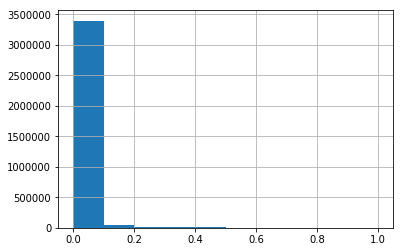

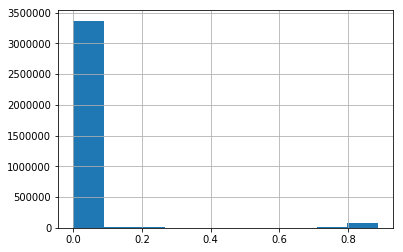

In [33]:
res_df.class_16.hist()
plt.show()
boost_df.class_16.hist()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6debdea828>,
      dtype=object)

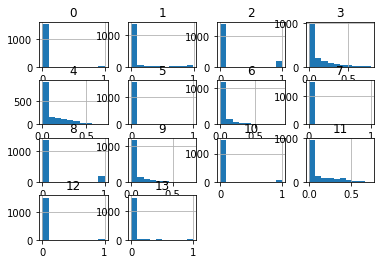

In [60]:
# val の段階ではいい感じに分布してる
pd.DataFrame(torch.nn.functional.softmax(best_val_res).detach().numpy()).hist()

Index(['class_6', 'class_15', 'class_16', 'class_42', 'class_52', 'class_53',
       'class_62', 'class_64', 'class_65', 'class_67', 'class_88', 'class_90',
       'class_92', 'class_95', 'class_99'],
      dtype='object')


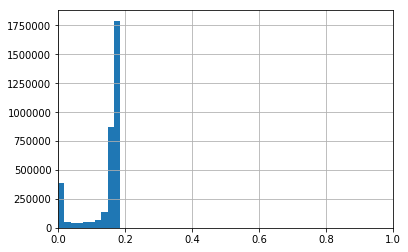

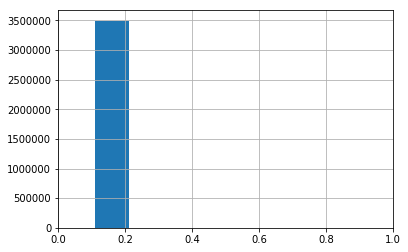

In [54]:
class_num = 99
print(res_df.columns)
res_df[f'class_{class_num}'].hist()
plt.xlim((0, 1))
plt.show()
boost_df[f'class_{class_num}'].hist()
plt.xlim((0, 1))
plt.show()

In [38]:
boost_df = pd.read_csv('../submissions/Booster_weight-multi-logloss-0.579991_2018-11-18-12-47-32.csv')

In [86]:
#temp = pd.DataFrame(test_reses[0].detach().numpy())
temp = pd.read_csv('../submissions/PLASTICC_NET_weight-multi-logloss-0.682721.csv').values
np.sum(temp, axis=1)

array([1.41724978e+01, 1.53105914e+01, 1.82712079e+01, ...,
       1.30787975e+08, 1.30788054e+08, 1.30788055e+08])

In [68]:
np.max(x_test), np.min(x_test)

(1.9639362475017719, -2.326753765513524)

In [105]:
test_reses[0][4]

array([1.0000000e+00, 0.0000000e+00, 9.8090893e-45, 0.0000000e+00,
       0.0000000e+00, 3.3028452e-11, 2.0108591e-39, 0.0000000e+00,
       3.1313738e-30, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.1544093e-38, 5.8501185e-27], dtype=float32)

In [67]:
x_train = train_df.drop('target', axis=1).values
x_test = test_df.drop('index', axis=1).fillna(train_df.drop('target', axis=1).mean()).values

In [68]:
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_train

array([[-5.18380630e-01, -4.86671381e-14, -1.16345067e-16, ...,
         1.33838658e-01, -1.33838658e-01,  1.54126048e+00],
       [ 3.31299785e-01,  2.18246819e+00,  2.13518888e+00, ...,
        -3.64754037e+00,  3.64754037e+00, -6.48819594e-01],
       [-4.66107971e-01, -5.31010073e-01, -5.32243589e-01, ...,
         1.39008276e-01, -1.39008276e-01, -6.48819594e-01],
       ...,
       [-5.18380630e-01, -4.86671381e-14, -1.16345067e-16, ...,
        -1.19765889e+00,  1.19765889e+00,  1.54126048e+00],
       [-5.18380630e-01, -4.86671381e-14, -1.16345067e-16, ...,
         3.59736690e-01, -3.59736690e-01,  1.54126048e+00],
       [-5.18380630e-01, -4.86671381e-14, -1.16345067e-16, ...,
         6.44381257e-01, -6.44381257e-01,  1.54126048e+00]])

In [74]:
x_test = ss.transform(x_test)

In [75]:
np.isnan(x_test).any()

False